In [1]:
!pip install --upgrade nltk
!pip install wordcloud
!pip install textblob

Requirement already up-to-date: nltk in /home/jupyterlab/conda/lib/python3.6/site-packages (3.4)
    100% |████████████████████████████████| 368kB 19.0MB/s 
    100% |████████████████████████████████| 645kB 17.6MB/s 


In [2]:
import ibm_db
import ibm_db_dbi
import os
import re
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
nltk.download("stopwords")
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#Replace the placeholder values with the actuals for your Db2 Service Credentials
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net"            # e.g.: "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_port = "50000"                    # e.g. "50000" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_uid = "dnl28708"                 # e.g. "abc12345"
dsn_pwd = "9mk12bvv3r-b3vw9"                 # e.g. "7dBZ3wWt9XN6$o0J"

## Task 3: Create the database connection

Ibm_db API uses the IBM Data Server Driver for ODBC and CLI APIs to connect to IBM DB2 and Informix.


Create the database connection


In [4]:
#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

# try:
#     conn = ibm_db.connect(dsn, "", "")
#     print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

# except:
#     print ("Unable to connect: ", ibm_db.conn_errormsg() )


## Task 3: Create the database connection

Ibm_db API uses the IBM Data Server Driver for ODBC and CLI APIs to connect to IBM DB2 and Informix.


Create the database connection


In [5]:
def DB2Connect(query):
    """
    Connects to database and extracts
    raw tweets and any other columns we
    need
    Parameters:
    ----------------
    arg1: string: SQL query
    Returns: Pandas Dataframe
    ----------------
    """

    try:
        con = ibm_db.connect(dsn, "", "")
        conn = ibm_db_dbi.Connection(con)   
        cur = conn.cursor()
        cur.execute(query)
        data = cur.fetchall()
        # store in dataframe
        df = pd.DataFrame(data,columns = ['date', 'tweet'])

    except :
        print(ibm_db.conn_errormsg())

    cur.close()
    conn.close()

    return df

class TweetObject():

#     def __init__(self,dsn):
#         self.dsn = dsn
    
    
    def clean_tweets(self, df):
        """
        Takes raw tweets and cleans them
        so we can carry out analysis
        remove stopwords, punctuation,
        lower case, html, emoticons.
        This will be done using Regex
        ? means option so colou?r matches
        both color and colour.
        """

        # Do some text preprocessing
        stopword_list = stopwords.words('english')
        ps = PorterStemmer()
        df["clean_tweets"] = None
        df['len'] = None
        for i in range(0,len(df['tweet'])):
        # get rid of anythin that isnt a letter
            exclusion_list = ['[^a-zA-Z]','rt', 'http', 'co', 'RT']
            exclusions = '|'.join(exclusion_list)
            text = re.sub(exclusions, ' ' , df['tweet'][i])
            text = text.lower()
            words = text.split()
            words = [word for word in words if not word in stopword_list]
            # only use stem of word
            #words = [ps.stem(word) for word in words]
            df['clean_tweets'][i] = ' '.join(words)


        # Create column with data length
            #df['len'] = np.array([len(tweet) for tweet in data["clean_tweets"]])
        return df

    def sentiment(self, tweet):
        """
        This function calculates sentiment
        on our cleaned tweets.
        Uses textblob to calculate polarity.
        Parameters:
        ----------------
        arg1: takes in a tweet (row of dataframe)
        """

        # need to improce
        analysis = TextBlob(tweet)
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
        
    def save_to_csv(self, df):
        """
        Save cleaned data to a csv for further
        analysis.
        Parameters:
        ----------------
        arg1: Pandas dataframe
        """
        try:
            df.to_csv("D:/Twitter/clean_tweets.csv")
            print("\n")
            print("csv successfully saved. \n")

        except Exception as e:
            print(e)

    def word_cloud(self, df):
        plt.subplots(figsize = (12,10))
        wordcloud = WordCloud(
                    background_color = 'white',
                    width = 1000,
                    height = 800).generate(" ".join(df['clean_tweets']))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()

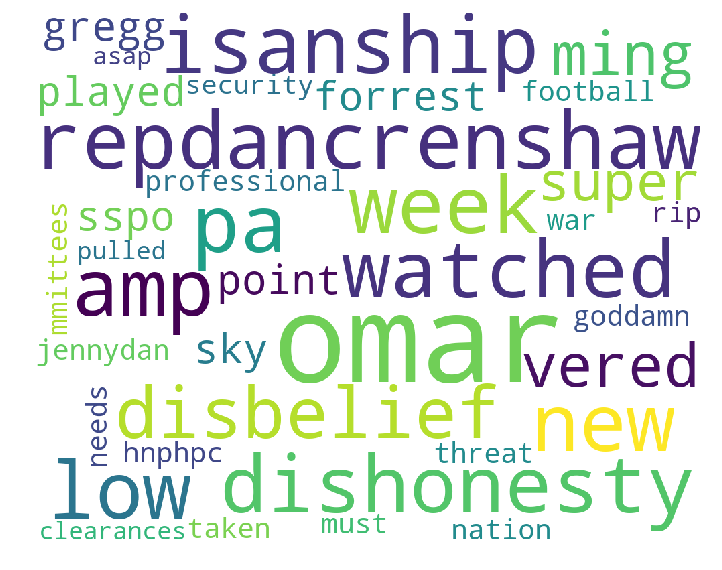

[Errno 2] No such file or directory: 'D:/Twitter/clean_tweets.csv'
percentage of positive tweets: 75.0%
percentage of negative tweets: 0.0%
percentage of neutral tweets: 25.0%


In [6]:

if __name__ == '__main__':

    t = TweetObject()
    data  = DB2Connect("SELECT created_at, tweet from FOOTBALL")
    #data  = t.DB2Connect("SELECT created_at, tweet from FOOTBALL")
    data = t.clean_tweets(data)
    data['Sentiment'] = np.array([t.sentiment(x) for x in data['clean_tweets']])
    t.word_cloud(data)
    t.save_to_csv(data)

    pos_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] > 0]
    neg_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] < 0]
    neu_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] == 0]

    #Print results
    print("percentage of positive tweets: {}%".format(100*(len(pos_tweets)/len(data['clean_tweets']))))
    print("percentage of negative tweets: {}%".format(100*(len(neg_tweets)/len(data['clean_tweets']))))
    print("percentage of neutral tweets: {}%".format(100*(len(neu_tweets)/len(data['clean_tweets']))))


In [5]:
con = ibm_db.connect(dsn, "", "")
conn = ibm_db_dbi.Connection(con)
cur = conn.cursor()
query = "SELECT created_at, tweet from FOOTBALL"
cur.execute(query)
data = cur.fetchall()

In [18]:
t = TweetObject(dsn)
try:
    date = t.DB2Connect("SELECT created_at, tweet from FOOTBALL")
except Exception as e:
    print(e)



local variable 'cur' referenced before assignment


In [17]:
date

NameError: name 'date' is not defined

In [39]:
%load_ext sql
%sql ibm_db_sa://dnl28708:9mk12bvv3r-b3vw9@dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net:50000/BLUDB

'Connected: dnl28708@BLUDB'

In [41]:
%sql SELECT created_at, tweet from FOOTBALL

 * ibm_db_sa://dnl28708:***@dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net:50000/BLUDB
Done.


created_at,tweet
2019-04-12 19:48:26.000000000,RT @SerieTV46: iTunes US album:#1 #BTS - MAP OF THE SOUL: PERSONA#34 #BLACKPINK - Kill This Love#95 #RM - mono.#177 #TXT - STAR#224 B…
2019-04-12 19:48:26.000000000,RT @Ang3linababy: What’s your favourite line in Ronaldo? Check out the full video here: https://t.co/ZNzyeNVdGO https://t.co/Cr1l9zzK2E
2019-04-12 19:48:27.000000000,LATEST POD 👇🏾👇
2019-04-12 19:48:28.000000000,RT @SerieTV46: iTunes US album:#1 #BTS - MAP OF THE SOUL: PERSONA#34 #BLACKPINK - Kill This Love#95 #RM - mono.#177 #TXT - STAR#224 B…
2019-04-12 19:48:29.000000000,@akajimalo @DzvitiErnest @AMendes029 @ChampionsLeague @juventusfcen @Cristiano I’m a good debater lol. Just watch c… https://t.co/FUIrmXGv9C
2019-04-12 19:48:29.000000000,RT @SerieTV46: iTunes US album:#1 #BTS - MAP OF THE SOUL: PERSONA#34 #BLACKPINK - Kill This Love#95 #RM - mono.#177 #TXT - STAR#224 B…
2019-04-12 19:48:30.000000000,RT @fallfalljjjj: Club World Cup 2015 Final FC Barcelona &amp; #RiverPlateWarm UP#fcwc #FCB #barca #Messi #Neymarhttps://t.co/lguKjKiT7q
2019-04-12 19:48:31.000000000,"RT @Nikilled: Without this feat, no three-peat. https://t.co/AnaOks4de7"
2019-04-12 19:48:33.000000000,"RT @FCBarcelonaFl: 🗣 Bernardo Silva (Manchester City) ""I believe that the strength of our team is not having a player like Cristiano or Mes"
2019-04-12 19:48:34.000000000,RT @SerieTV46: iTunes US album:#1 #BTS - MAP OF THE SOUL: PERSONA#34 #BLACKPINK - Kill This Love#95 #RM - mono.#177 #TXT - STAR#224 B…
